<a href="https://colab.research.google.com/github/OmriMan/Souped-up-Regression-Trees/blob/main/Souped_upRegressionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ENSEMBLE LEARNING**

Exercise 1: Souped-up Regression Trees


Introduction:
The default implementation of Decision Trees for Regression in the scikit-learn library does not support using a regression method in the leaves of the tree. In this exercise you implement solutions to this problem, and you will evaluate their effect on predictive performance.

**Packages**

In [277]:
import numpy as np  # linear algebra
import pandas as pd  # data processing
import sklearn
from sklearn.tree import DecisionTreeRegressor  # model
from matplotlib import pyplot as plt  # visualization
from sklearn.tree import plot_tree  # visualize tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

**preprocess**

In [278]:
# from pandas.compat import numpy
def WordDescreptionToNumbers(word_list):
  '''
      Ex	Excellent = 5
      Gd	Good = 4
      TA	Average/Typical = 3
      Fa	Fair = 2
      Po	Poor = 1
      NA No
  '''
  word_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
  return [word_dict[word] for word in word_list]

def HeatingWordDescreptionToNumbers(word_list):
  '''
        Floor	Floor Furnace
        GasA	Gas forced warm air furnace
        GasW	Gas hot water or steam heat
        Grav	Gravity furnace	
        OthW	Hot water or steam heat other than gas
        Wall	Wall furnace
  '''
  heating_word_dict = {'Floor': 6 , 'GasA' : 5 , 'GasW' : 4 , 'Grav' : 3 ,'OthW': 2 , 'Wall' : 1}
  return [heating_word_dict[word] for word in word_list]


def na_to_zero(values):
  return [i if not np.isnan(i) else 0 for i in values]



In [279]:
def preprocess(df):
    cols_to_drop = [col for col in df.columns if col not in ['Pool','PoolArea','LotFrontage','OverallQual','LotArea','NewCostruction','OverallCond','ExterQual','ExterCond','Heating','WoodDeckSF','GarageArea','SalePrice']]
    cols_to_drop.append('PoolArea')
    df['Pool'] = (df['PoolArea'] > 0).astype('int64')
    df['NewConstruction'] = (df['SaleType'] == 'New').astype('int64')
    #ExterQual: Evaluates the quality of the material on the exterior
    df ['ExterQual'] = WordDescreptionToNumbers(df['ExterQual'])
    #ExterCond: Evaluates the present condition of the material on the exterior
    df['ExterCond'] = WordDescreptionToNumbers(df['ExterCond'])
    df['Heating'] = HeatingWordDescreptionToNumbers(df['Heating'])
    df['LotFrontage'] = na_to_zero(df['LotFrontage'])
    df['SalePrice'] = df['SalePrice'] // 1000
    # df['SalePrice'] = df['SalePrice']
    df = df.drop(columns=cols_to_drop)
    # df = df[['NewConstruction', 'Pool', 'LotArea','OverallQual', 'SalePrice']]
    
    return df

**"house_prices" Dataset** (https://www.kaggle.com/code/chazzer/ml-grandmaster-decision-tree-regressor/data)

In [280]:
df = pd.read_csv('/content/sample_data/house_prices_train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [281]:
df1 = df.loc[df.index.isin([i for i in range(1000)])]
df1 = preprocess(df1)
# df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

**Target (sale price)  distribution**

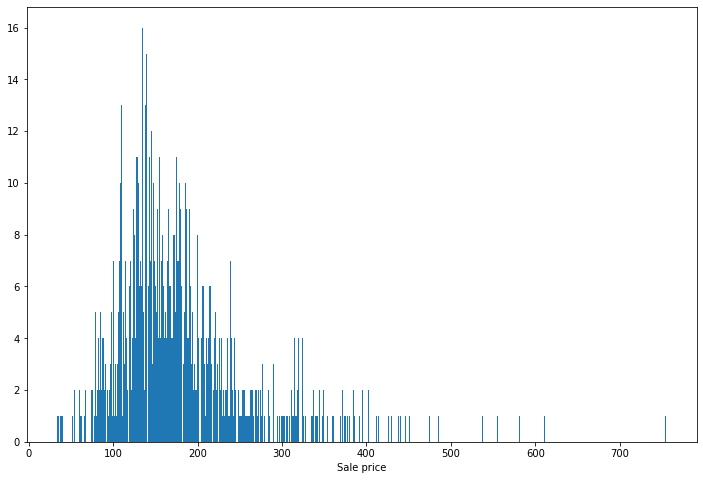

In [282]:
sale_price = df1['SalePrice']

plt.figure(figsize=(12, 8))
plt.hist(sale_price,max(sale_price))
plt.xlabel("Sale price")
plt.show()

**Sanity check**

In [283]:
import collections
#Sanity check
#(sale price value , The number of samples with the same value)
print([(item,count) for item, count in collections.Counter(sale_price).items() if count > 1])

[(208, 3), (181, 6), (223, 2), (140, 15), (250, 6), (143, 11), (200, 8), (129, 11), (118, 10), (345, 2), (144, 7), (157, 7), (132, 10), (149, 7), (90, 2), (159, 8), (139, 13), (325, 4), (230, 4), (154, 4), (256, 2), (134, 6), (207, 6), (179, 10), (165, 9), (277, 3), (145, 12), (153, 9), (109, 10), (82, 4), (160, 6), (170, 4), (130, 10), (141, 9), (319, 2), (239, 7), (113, 5), (127, 10), (177, 4), (114, 3), (110, 13), (385, 2), (180, 9), (172, 8), (196, 3), (124, 9), (158, 7), (202, 4), (219, 2), (226, 4), (225, 5), (244, 4), (185, 10), (107, 6), (91, 3), (135, 16), (136, 5), (193, 3), (245, 2), (126, 4), (168, 6), (260, 5), (174, 5), (164, 7), (85, 5), (123, 4), (98, 5), (163, 4), (133, 7), (204, 4), (214, 6), (94, 2), (128, 11), (205, 6), (178, 7), (198, 2), (169, 4), (100, 7), (115, 7), (190, 9), (217, 3), (176, 7), (155, 11), (320, 4), (84, 2), (87, 4), (150, 6), (220, 4), (171, 4), (231, 2), (166, 2), (125, 8), (105, 3), (222, 5), (122, 4), (372, 2), (235, 4), (79, 5), (269, 2), (2

In [284]:
# defining our tree object with the defult hyper parameters criterion='squared_error',splitter='best'
#not defult parameter: max_depth = 5
model = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth = 5
)

# CART algorithm that builds the tree based on our data
model.fit(
    X=df1.drop(columns=['SalePrice']), 
    y=df1['SalePrice']
)

DecisionTreeRegressor(max_depth=5)

 **using 5-fold CV**

In [285]:
score = cross_val_score(model, df1.drop(columns=['SalePrice']), df1['SalePrice'], cv=5)
print(score)
print(f"standard deviation of {score.std()}" )

[0.71922266 0.74719012 0.71834644 0.66730328 0.7051073 ]
standard deviation of 0.025978807507295282


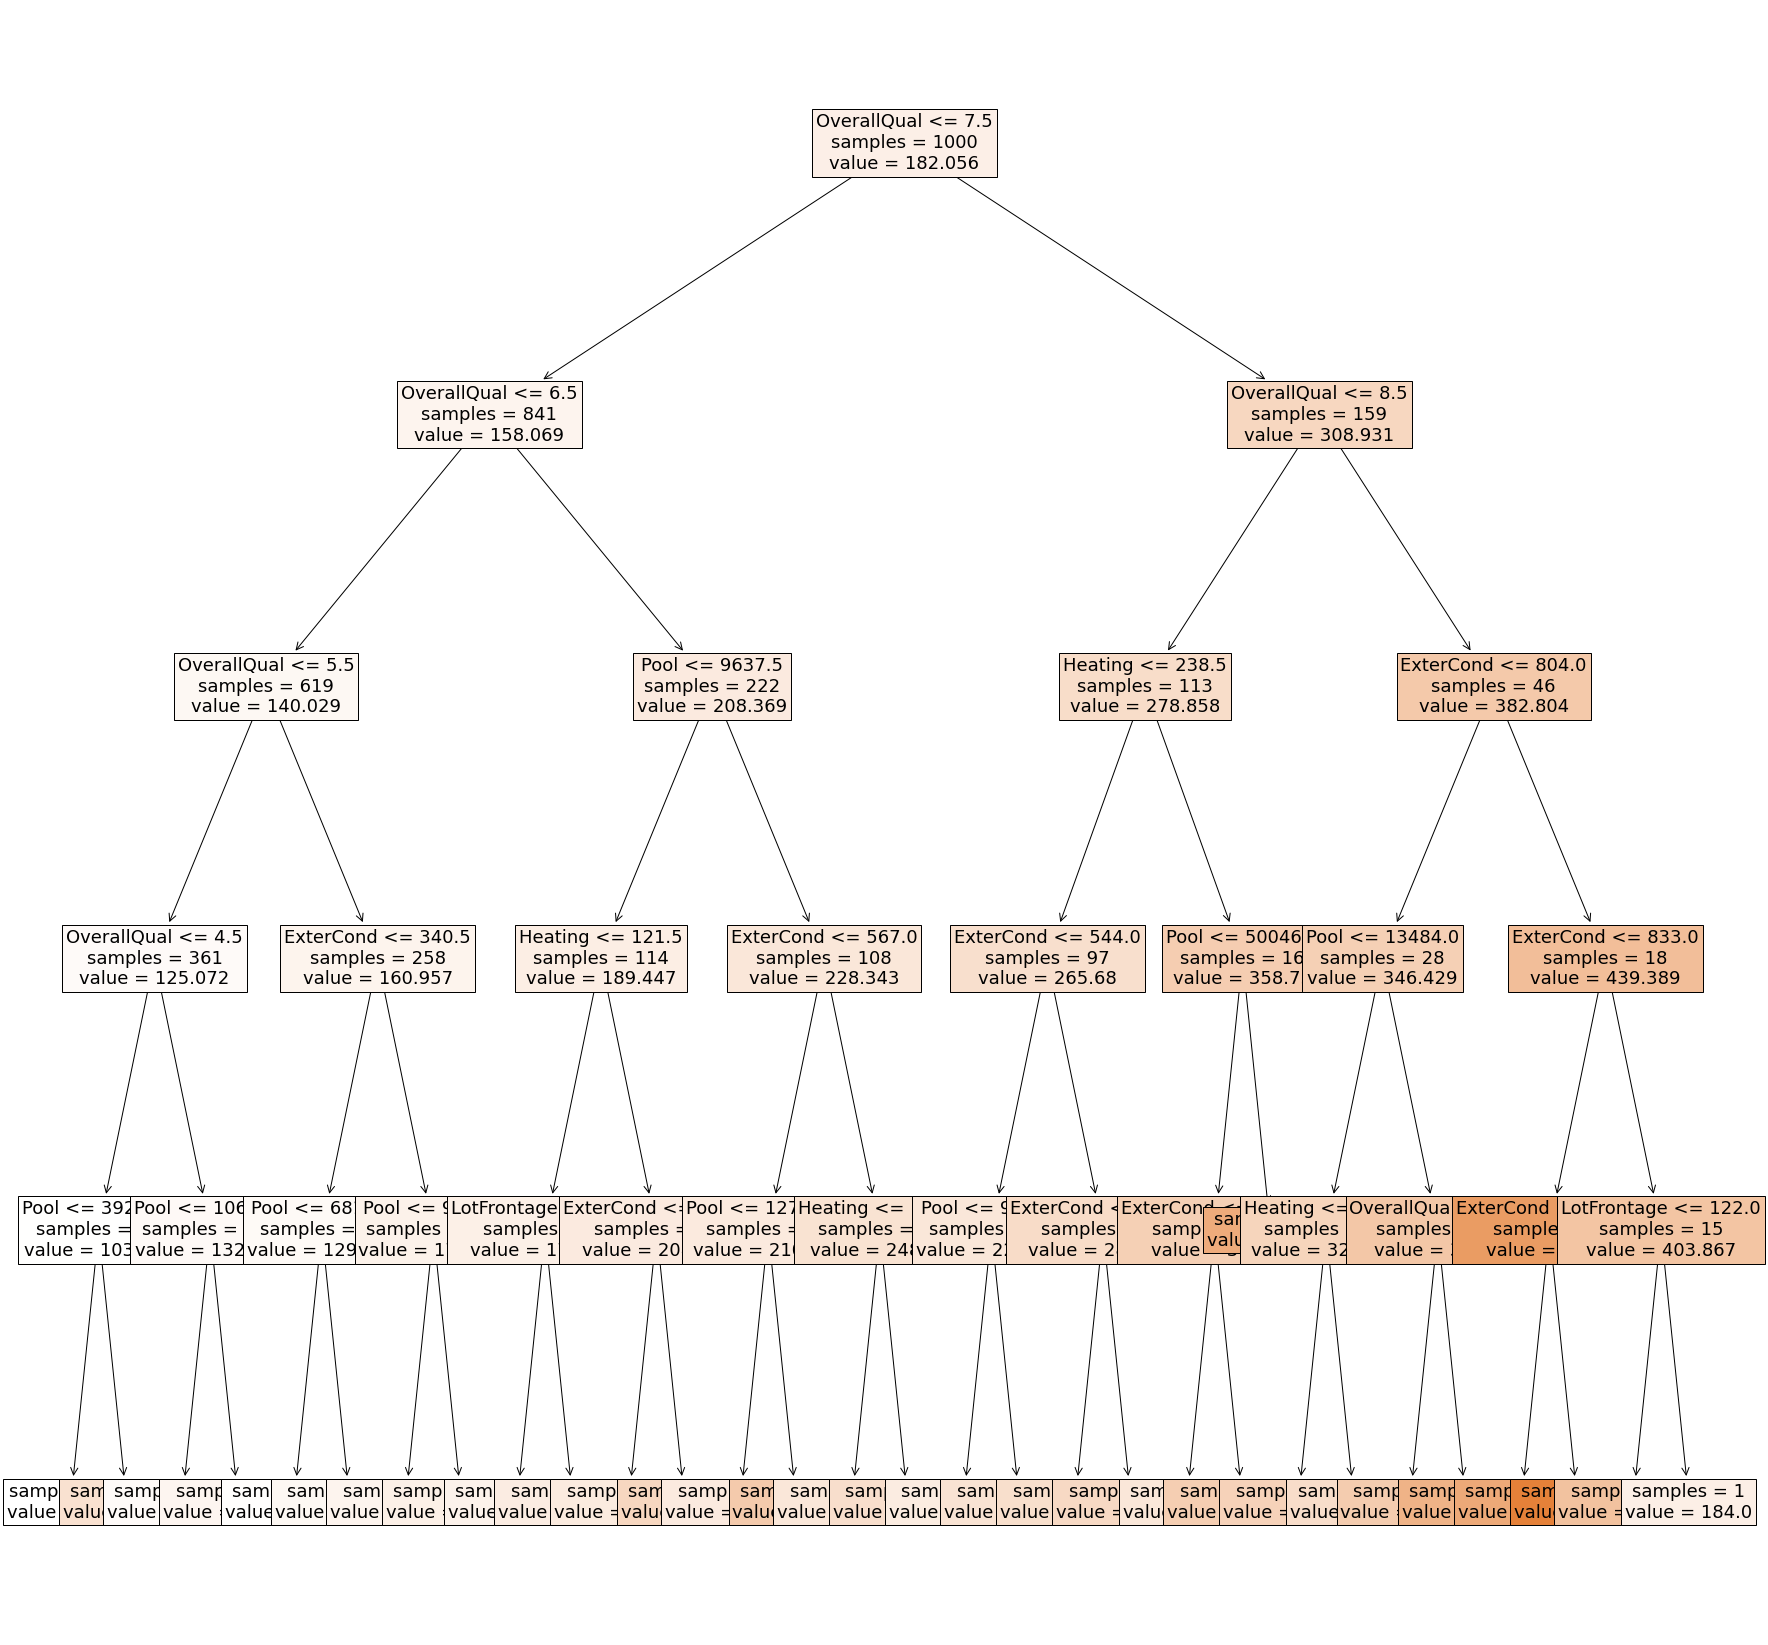

In [286]:
plt.figure(figsize=(30, 30))
plot_tree(
    model,
    feature_names=['LotFrontage','Pool','OverallQual','LotArea','NewCostruction','OverallCond','ExterQual','ExterCond','Heating','GarageArea','WoodDeckSF'],
    impurity=False,
    filled=True,
    fontsize=18
)
plt.show()

In [287]:
#Sanity check
inputs = pd.DataFrame([{"LotFrontage": 64,"LotArea": 10206,"OverallQual":3,"OverallCond":3,"ExterQual":3,"ExterCond":3,"Heating":4,"GarageArea":632 ,"WoodDeckSF":105,"Pool": 0,"NewConstruction": 0}])
prediction = model.predict(inputs)
print(f"Predicted SalePrice: {prediction}")

#sample number 1001
# 82000

Predicted SalePrice: [101.5]


**Test and evaluation**

In [288]:
df_test = df.loc[df.index.isin([i for i in range(1000,1460)])]
df_test = preprocess(df_test)
# df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

**Regression metrics:**


---


**mean_squared_error :**
The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.


---

 **R² score :**
 the coefficient of determination
 The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent,R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected (average) value of y, disregarding the input features, would get an R² score of 0.0.

In [289]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
y_true,y_pred = [],[]
for i in df_test.index:
  # print(i)
  # print({"NewConstruction": df_test["NewConstruction"][i], "Pool": df_test["Pool"][i],"OverallQual":df_test["OverallQual"][i],"OverallCond":df_test["OverallCond"][i],"ExterQual":df_test["ExterQual"][i],"ExterCond":df_test["ExterCond"][i],"Heating":df_test["Heating"][i], "LotArea": df_test["LotArea"][i]})
  inputs = pd.DataFrame([{"LotFrontage":df_test["LotFrontage"][i] , "LotArea": df_test["LotArea"][i],"OverallQual":df_test["OverallQual"][i],"OverallCond":df_test["OverallCond"][i],"ExterQual":df_test["ExterQual"][i],"ExterCond":df_test["ExterCond"][i],"Heating":df_test["Heating"][i],"GarageArea":df_test["GarageArea"][i],"WoodDeckSF":df_test["WoodDeckSF"][i],"Pool": df_test["Pool"][i],"NewConstruction": df_test["NewConstruction"][i]}])
  '''
  use the predict method to derive the SalePrice
  y_pred - A list of the values ​​that the model predicted 
  y_true - A list of the actual values

  '''
  prediction = model.predict(inputs)
  y_pred.append(prediction)
  y_true.append(df_test['SalePrice'][i])
  # print(f"Predicted SalePrice: {prediction} , Real SalePrice: {df_test['SalePrice'][i]}")

'''
Calculation of MSE and R2
'''
#MSE
mse = mean_squared_error(y_true, y_pred,squared=False)
print(f"mean_squared_error(y_true, y_pred): {mse}")
#R2
r2 = r2_score(y_true, y_pred)
print(f"r2_score(y_true, y_pred): {r2}")
# r2_score(y_true, y_pred, multioutput='uniform_average')



mean_squared_error(y_true, y_pred): 40.50634322813406
r2_score(y_true, y_pred): 0.7267715219260941


In [290]:
from tabulate import tabulate
print(tabulate([[mse,r2]], headers=["MSE","R2"], tablefmt="grid"))

+---------+----------+
|     MSE |       R2 |
+=========+==========+
| 40.5063 | 0.726772 |
+---------+----------+


In the following graph the green stars mark the real value of the price and the blue dots the predicted value:

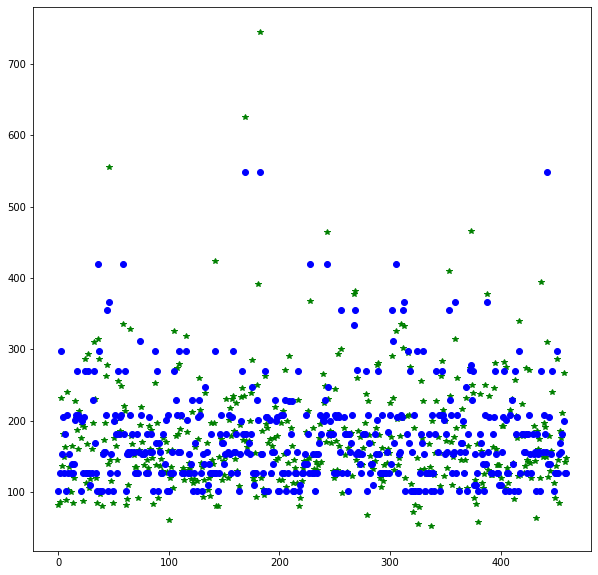

In [291]:
plt.figure(figsize=(10, 10))
plt.plot(y_true,'g*', y_pred, 'bo')
plt.show()

**Implement a modified decision tree where the leaves of the tree use a Linear Regression in each leaf**

https://github.com/cerlymarco/linear-tree

In [292]:
# pip install --upgrade linear-tree

In [293]:
from lineartree import LinearTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [294]:
df = pd.read_csv('/content/sample_data/house_prices_train.csv')
df_regressor = df.loc[df.index.isin([i for i in range(1000)])]
df_regressor = preprocess(df_regressor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [295]:
regressor = LinearTreeRegressor(base_estimator=LinearRegression())
regressor.fit(
    X=df_regressor.drop(columns=['SalePrice']), 
    y=df_regressor['SalePrice']
)


score = cross_val_score(regressor, df_regressor.drop(columns=['SalePrice']), df_regressor['SalePrice'], cv=5)
print(score)
print(f"standard deviation of {score.std()}")


[ 0.80636927 -0.01479526  0.69196153  0.7061374   0.67595772]
standard deviation of 0.29747003689742973


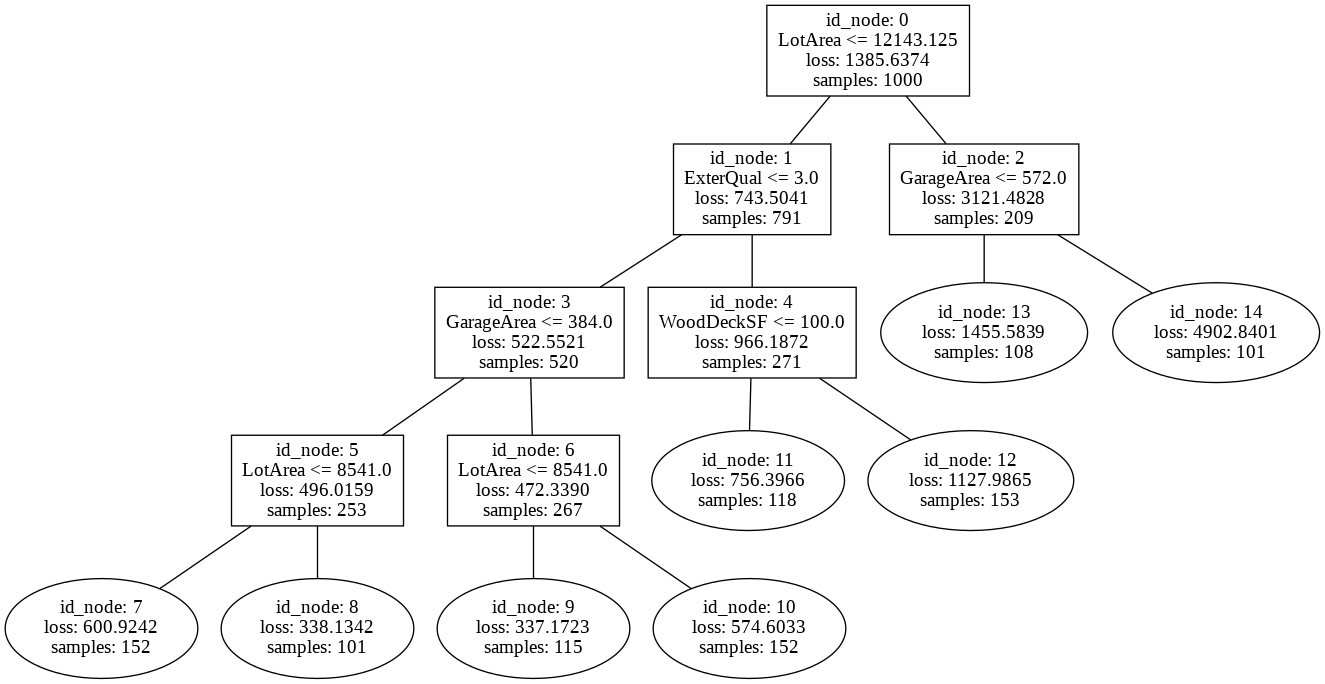

In [301]:
# print(df_regressor)
regressor.plot_model(feature_names=['LotFrontage','LotArea','OverallQual','OverallCond','ExterQual','ExterCond','Heating','GarageArea','WoodDeckSF','Pool','NewCostruction'])

In [297]:
#Sanity check
inputs = pd.DataFrame([{"LotFrontage": 64,"LotArea": 10206,"OverallQual":3,"OverallCond":3,"ExterQual":3,"ExterCond":3,"Heating":4,"GarageArea":632 ,"WoodDeckSF":105,"Pool": 0,"NewConstruction": 0}])
prediction = regressor.predict(inputs)
print(f"Predicted SalePrice: {prediction}")

#sample number 1001
# 82000

Predicted SalePrice: [95.46412659]


In [298]:
df_test = df.loc[df.index.isin([i for i in range(1000,1460)])]
df_test = preprocess(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [299]:
y_true,y_pred_regressor = [],[]
for i in df_test.index:
  # print({"NewConstruction": df_test["NewConstruction"][i], "Pool": df_test["Pool"][i],"OverallQual":df_test["OverallQual"][i],"OverallCond":df_test["OverallCond"][i],"ExterQual":df_test["ExterQual"][i],"ExterCond":df_test["ExterCond"][i],"Heating":df_test["Heating"][i], "LotArea": df_test["LotArea"][i]})
  inputs = pd.DataFrame([{"LotFrontage":df_test["LotFrontage"][i] , "LotArea": df_test["LotArea"][i],"OverallQual":df_test["OverallQual"][i],"OverallCond":df_test["OverallCond"][i],"ExterQual":df_test["ExterQual"][i],"ExterCond":df_test["ExterCond"][i],"Heating":df_test["Heating"][i],"GarageArea":df_test["GarageArea"][i],"WoodDeckSF":df_test["WoodDeckSF"][i],"Pool": df_test["Pool"][i],"NewConstruction": df_test["NewConstruction"][i]}])
  '''
  use the predict method to derive the SalePrice
  y_pred_regressor - A list of the values ​​that the model predicted 
  y_true - A list of the actual values

  '''
  prediction = regressor.predict(inputs)
  y_pred_regressor.append(prediction)
  y_true.append(df_test['SalePrice'][i])
  # print(f"Predicted SalePrice: {prediction} , Real SalePrice: {df_test['SalePrice'][i]}")

'''
Calculation of MSE and R2
'''
#MSE
mse_regressor = mean_squared_error(y_true, y_pred_regressor,squared=False)
print(f"mean_squared_error(y_true, y_pred_regressor): {mse_regressor}")
#R2
r2_regressor = r2_score(y_true, y_pred_regressor)
print(f"r2_score(y_true, y_pred_regressor): {r2_regressor}")
# r2_score(y_true, y_pred, multioutput='uniform_average')

mean_squared_error(y_true, y_pred_regressor): 41.478360313712535
r2_score(y_true, y_pred_regressor): 0.7135010424181508


In the following graph the green stars mark the real value of the price and the blue dots the predicted value:

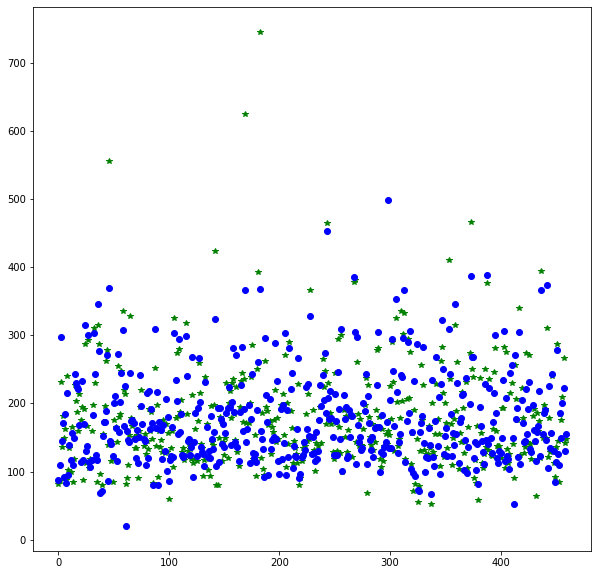

In [302]:
plt.figure(figsize=(10, 10))
plt.plot(y_true,'g*', y_pred_regressor, 'bo')
plt.show()

In [300]:
print(tabulate([[mse,mse_regressor,r2,r2_regressor]], headers=["MSE","MES Linear Regression","R2", "R2 Linear Regression"], tablefmt="grid"))

+---------+-------------------------+----------+------------------------+
|     MSE |   MES Linear Regression |       R2 |   R2 Linear Regression |
+=========+=========================+==========+========================+
| 40.5063 |                 41.4784 | 0.726772 |               0.713501 |
+---------+-------------------------+----------+------------------------+
